In [3]:
!git add .

In [124]:
!git commit -m "data set 분리"
!git push origin main

현재 브랜치 main
브랜치가 'origin/main'에 맞게 업데이트된 상태입니다.

커밋하도록 정하지 않은 변경 사항:
  (무엇을 커밋할지 바꾸려면 "git add <파일>..."을 사용하십시오)
  (use "git restore <file>..." to discard changes in working directory)
	수정함:        "01_\353\215\260\354\235\264\355\204\260\354\205\213_\352\265\254\354\266\225_\354\275\224\353\223\234.ipynb"

커밋할 변경 사항을 추가하지 않았습니다 ("git add" 및/또는 "git commit -a"를
사용하십시오)
Everything up-to-date


# 0. 객체탐지(b-box) 모델을 조사
- 조사한 모델이 예상 성능 요구 사항을 충족시킬 수 있는지 확인해주세요. 확인한 내용을 **PPT 1장~3장**으로 정리해서 제출해주세요.
- 모델의 라이센스, 오픈 모델의 성능을 파악해서 왜 해당 모델을 선택했는지 작성이 되어야합니다.
- 업무요청 가이드에서는 yolov5 모델을 baseline모델로 사용하라고 되어있지만, 다른 b-box 모델을 조사했을 때 더 좋은 성능의 모델이 있다면 그 모델로 진행해도 좋습니다.


# 데이터셋 구축
- 아래의 코드 가이드를 참고해서 데이터셋 구축하는 코드를 작성해주세요
- 완료된 데이터셋 구축 코드는 **.ipynb 파일을 다운해서 제출**해주세요.

# 1. Mount google drive
- 코랩을 활용할 경우, 구글 드라이브에 있는 데이터를 사용하기 위해서 마운트 작업이 필요합니다.
- 로컬에서 진행할 경우엔 생략해주세요.
- 로컬에서 진행할 경우엔 conda를 활용하여 가상환경을 세팅해주세요.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Import Library
- 코드에 사용되는 파이썬 라이브러리를 불러옵니다.

In [122]:
import os
import cv2
import glob
import shutil
import warnings
import matplotlib.pyplot as plt

from tqdm.auto import tqdm       # 작업 진행 속도를 보는데 유용한 라이브러리입니다.
from sklearn.model_selection import train_test_split

In [120]:
!pip show tqdm

Name: tqdm
Version: 4.66.4
Summary: Fast, Extensible Progress Meter
Home-page: https://tqdm.github.io
Author: 
Author-email: 
License: MPL-2.0 AND MIT
Location: /opt/anaconda3/lib/python3.12/site-packages
Requires: 
Required-by: anaconda-client, anaconda-project, conda, conda-build, huggingface-hub, nltk, sentence-transformers, transformers


In [10]:
!pip install --upgrade jupyter ipywidgets
!pip install jupyterlab-widgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 34.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [14]:
# warning 무시 코드
warnings.filterwarnings(action='ignore')

In [16]:
# 현재 실행 파일 경로 확인
os.getcwd()

'/Users/tasha/Desktop/comento/mywork'

# 3. 데이터셋 준비
- 데이콘의 데이터셋은 차종으로 라벨링 되어 있는데, 우리는 차 종류를 객체탐지하는 것이 아닌 "차"를 객체탐지하는 것이 목표입니다.
- 차 종류로 라벨링 된 text파일 데이터를 수정해야합니다.

In [12]:
# 기존에 존재하던 데이터셋 폴더 경로 정의
origin_dir = '/Users/tasha/Desktop/comento/dataset/train'  # ex: '/content/drive/MyDrive/comento/1/dataset/data'

import glob

# 원본 라벨파일(.txt) 불러오기
origin_label = f'{origin_dir}/*.txt'
label_txts = glob.glob(origin_label)

print('라벨파일(.txt) 개수 : ',len(label_txts))

라벨파일(.txt) 개수 :  6481


In [10]:
# 수정된 라벨을 저장하는 폴더 경로 정의
edit_label_dir = '/Users/tasha/Desktop/comento/dataset/label_data' # ex: '/content/drive/MyDrive/comento/1/dataset/label_data'

import os

# 수정된 라벨링 데이터 저장 폴더를 생성
if not os.path.exists(edit_label_dir):
    os.mkdir(edit_label_dir)

# 4. Yolo 모델링을 위한 라벨링 데이터 수정
- 모든 데이터의 라벨을 "car"로 변경해야합니다.
- 기존 데이터셋의 Labelme 형태를 yolo format을 따라 라벨링 파일을 변경해야합니다.
- 참고 자료: https://docs.ultralytics.com/datasets/detect/#ultralytics-yolo-format


### 코드 설계 참고
- 코드를 작성하기 전에 구현하고자하는 로직을 텍스트로 설계해보는 연습도 많이 하면 좋을 것 같습니다.
1. 기존의 모든 라벨 데이터를 읽기모드로 불러와서 반복문으로 데이터 파일을 하나씩 열어줍니다.
2. 1번에서 불러온 라벨데이터(.txt)는 Labelme 형태로 <classId, x1, y1, x2, y2, x3, y3, x4, y4>에 맞게 값을 따로 정의해줍니다.
  - 참고 : strip().split(' ') 라이브러리 활용 가능
3. 모든 데이터의 라벨을 "car" 하나로만 변경해야하므로, classId는 0으로 변경해주세요
4. 2번에서 불러온 좌표값들을 활용하여 yolo 라벨 형태에 맞게 중심좌표와 너비/높이를 계산해줍니다.
5. 수정된 라벨을 새로운 파일로 저장해줍니다. (라벨 파일명은 매칭되는 이미지파일명과 동일해야합니다.)

In [88]:
# 라벨 데이터 수정 코드 작성

#1. 모든 라벨 데이터를 읽기 모드로 불러오기
origin_dir = '/Users/tasha/Desktop/comento/dataset/train' 
origin_label = f'{origin_dir}/*.txt'
label_txts = glob.glob(origin_label)

# 이미지 크기 
W, H = 1920, 1080 #데이터 값

for label_txt in label_txts:
    with open(label_txt, 'r') as f:
        lines = f.readlines()
        #for line in lines:
            #print(line.strip())

# 2. 1번에서 불러온 라벨데이터(.txt)는 Labelme 형태로 
#<classId, x1, y1, x2, y2, x3, y3, x4, y4>에 맞게 값을 따로 정의
    new_lines = []
    
    for line in lines: 
        data = list(map(float, line.strip().split(" "))) #공백 없앴고, ""로 나눠서

        #id 변경
        class_id = 0
    
        # 좌표
        x1, y1, x2, y2, x3, y3, x4, y4 = data[1:] 
    
    
    # 4. labelme 형태를 yolo 형식으로 변경,
    # yolo <classId> <x_center> <y_center> <width> <height>
        
        # 바운딩 박스 x, y의 최소/최댓값
        x_min = min(x1, x2, x3, x4)
        y_min = min(y1, y2, y3, y4) -2 # 박스 조금 아래로
        x_max = max(x1, x2, x3, x4)
        y_max = max(y1, y2, y3, y4) + 2 # 박스 조금 늘림 
    
        #좌표 계산 
        x_center = (x_min + x_max)/2
        y_center = (y_min + y_max)/2
        width = x_max - x_min
        height = y_max - y_min

        # y_center 오차 보정 (아래로)
        y_center += height * 0.06 # 5%밑으로 
    
        # 정규화 (0~1 범위) - 이미지 크기에 따라 헷갈리기 때문에, 정규화해야 함. 
        x_center /= W
        y_center /= H
        width /= W
        height /= H
    
        #새로운 yolo 형식 라벨 생성
        new_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

#5.수정된 라벨을 새로운 파일로 저장. (라벨 파일명은 매칭되는 이미지파일명과 동일해야합니다.)
    new_label_path = os.path.join(edit_label_dir, os.path.basename(label_txt)) #기존 파일명 유지
    with open(new_label_path, 'w') as f:
        f.writelines(new_lines)

print("저장 끝")

저장 끝


# 5. 라벨이 제대로 수정되었는지 확인하기
- 아래 함수를 통해 라벨이 제대로 수정되었는지 시각화해서 확인해주세요.
- 항상 작업을 완료후에는 결과를 확인하면서 이슈가 없는지 파악해야합니다.

읽은 라벨 개수: 3
클래스 0: (1037, 223) → (1335, 493)
클래스 0: (783, 437) → (1075, 718)
클래스 0: (315, 227) → (559, 470)


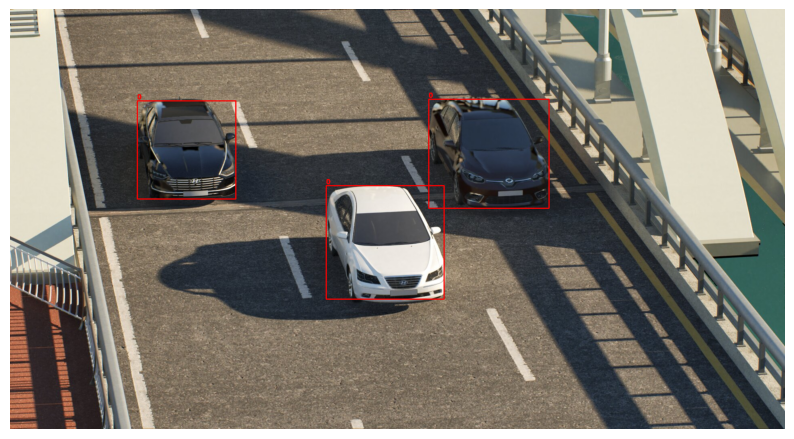

In [91]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image  # 필요 시 사용

def draw_boxes_on_image(image_path : str, annotation_path : str,
                        img_width : int, img_height : int):
    ''' 이미지와 바운딩 박스를 그리는 함수
    Args:
        image_path (str): 이미지 파일 경로
        annotation_path (str): 라벨 파일 경로 (.txt)
        img_width (int): 이미지의 너비
        img_height (int): 이미지의 높이
    Returns:
        show image: 이미지와 바운딩 박스가 그려진 이미지
    '''

    # 이미지 불러오기
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # txt 파일에서 Class ID와 Bounding Box 정보 읽기
    with open(annotation_path, 'r') as file:
        lines = file.readlines()

    print(f"읽은 라벨 개수: {len(lines)}")  # 몇 개의 바운딩 박스를 읽었는지 확인용

    for line in lines:
        values = list(map(float, line.strip().split(' ')))
        class_id = int(values[0])

        # YOLO 형식의 좌표를 원래 이미지 크기에 맞게 변환
        x_center = values[1] * img_width
        y_center = values[2] * img_height
        box_width = values[3] * img_width
        box_height = values[4] * img_height

        # 좌표 계산
        x_min = int(round(x_center - (box_width / 2)))
        y_min = int(round(y_center - (box_height / 2)))
        x_max = int(round(x_center + (box_width / 2)))
        y_max = int(round(y_center + (box_height / 2)))

        print(f"클래스 {class_id}: ({x_min}, {y_min}) → ({x_max}, {y_max})")  # 확인용


        # 이미지에 바운딩 박스 그리기
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.putText(image, str(class_id), (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # 이미지와 바운딩 박스 출력
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')  # 축 숨기기
    plt.show()


#### 검증 함수 실행!!
image_file = os.path.join(origin_dir, 'syn_00068.png')
annotation_file = os.path.join(edit_label_dir, 'syn_00068.txt')
img_width, img_height = Image.open(image_file).size

draw_boxes_on_image(image_file, annotation_file, img_width, img_height)

# 6. train/valid/test set 분리
- 간단한 데이터셋 통계량 확인하고, 데이터셋 비율을 정해줍니다.
  - 차량 데이터 총 개수 확인 (참고 : glob 모듈 사용)
- 학습/검증/테스트셋 분리
  - train_test_split 라이브러리를 활용하여 test_size 인자로 데이터셋 비율을 조절할 수 있습니다. (train_test_split라이브러리는 데이터셋을 분리하는데에 많이 사용되고 있습니다.)
  - trainset : validset : testset  = 6 : 2 : 2

In [113]:
# 학습/검증/테스트셋 분리
# glob : 특정 패턴을 가진 파일 경로 찾을 때 쓰는 파일 탐색 모듈 
# "*.txt" 같은 패턴을 지정하고 찾는 용 
from sklearn.model_selection import train_test_split

# 차량 데이터 총 개수 
data_dir = '/Users/tasha/Desktop/comento/dataset/train' 
imgs = glob.glob(os.path.join(data_dir,'*.png'))
print(f"차량 데이터 총 개수: {len(imgs)}")

# 같은 이름의 txt 라벨 파일 리스트 만들기
all_labels = [img.replace(".png", ".txt") for img in imgs] # txt, img 같이 나눠야 함. 

# 학습/검증/데트스 셋 분리 
# 1차 분할 :train (60%), 나머지 (40%)
X_train, X_temp, y_train, y_temp = train_test_split(imgs, all_labels, test_size=0.4, random_state=42)

# 2차 분할: validation (20%), test(20%)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # 반절 나누니깐

print(f"Train 개수: {len(X_train)}")
print(f"Validation 개수: {len(X_valid)}")
print(f"Test 개수: {len(X_test)}")

차량 데이터 총 개수: 6481
Train 개수: 3888
Validation 개수: 1296
Test 개수: 1297


# 7. 학습용 train/valid/test 데이터셋 폴더 생성

- 위에서 분리한 train/valid/testset을 옮겨둘 폴더를 생성하고, 파일을 복사해서 옮겨줍니다.
- 아래의 폴더 구조로 만들어주세요.

```
└── datasets /
    ├── images /
        ├── train /
            ├── 1.png
            ├── 2.png
        ├── val /
            ├── 3.png
            ├── 4.png
        ├── test /
            ├── 5.png
            ├── 6.png
    ├── labels /
        ├── train /
            ├── 1.txt
            ├── 2.txt
        ├── val /
            ├── 3.txt
            ├── 4.txt
        ├── test /
            ├── 5.txt
            ├── 6.txt
```

- 데이터를 저장하고자 하는 곳으로 이동 (참고 : shutil.copy 라이브러리 사용)
- 참고 자료: https://docs.ultralytics.com/datasets/detect/#ultralytics-yolo-format
- 구글드라이브의 용량이 부족하다면 데이터를 조금 더 삭제해서 줄여도 괜찮습니다.

In [ ]:
# 데이터셋 구축 코드 작성




- 학습에 사용되는 .yaml 파일을 아래 형식에 맞춰서 만들어줍니다.

```
names:
- car
nc: 1
path: "dataset_folder_root_path"
test: "test_image_dataset_folder_path"
train: "train_image_dataset_folder_path"
val: "validation_image_dataset_folder_path"
```

In [ ]:
# yaml 파일 생성 코드 작성 후 저장


In [ ]:
# 생성한 YAML 파일 읽기
yaml_path = 'Enter_your_yaml_file_path'

with open(yaml_path, 'r') as f:
    data = yaml.full_load(f)

# 내용 출력
print(data)

{'names': ['car'], 'nc': 1, 'path': '/content/drive/MyDrive/comento/1/datasets_yolo', 'test': '/content/drive/MyDrive/comento/1/datasets_yolo/images/test', 'train': '/content/drive/MyDrive/comento/1/datasets_yolo/images/train', 'val': '/content/drive/MyDrive/comento/1/datasets_yolo/images/val'}
